### Importing required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from pylab import rcParams
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
airline = pd.read_csv('airline-passenger-traffic.csv',header=None)
airline.head()

,0,1
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [4]:
airline.columns = ['Month','Passenger']
airline.head()

,Month,Passenger
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [5]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Month      144 non-null    object 
 1   Passenger  140 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [6]:
airline['Month'] = pd.to_datetime(airline['Month'], format='%Y-%m')
airline.head()

,Month,Passenger
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


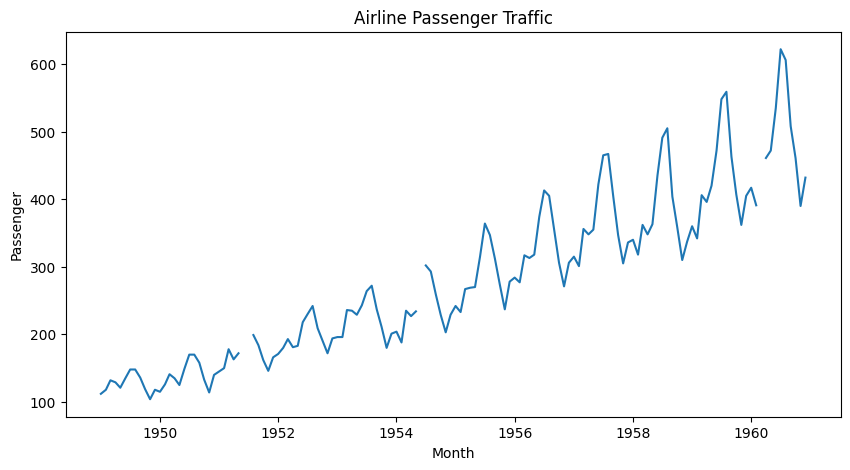

In [7]:
plt.figure(figsize=(10,5))
plt.plot(airline['Month'],airline['Passenger'])
plt.xlabel('Month')
plt.ylabel('Passenger')
plt.title('Airline Passenger Traffic')
plt.show()

In [8]:
airline.describe()

,Month,Passenger
count,144,140.000000
mean,1954-12-16 05:00:00,280.735714
min,1949-01-01 00:00:00,104.000000
25%,1951-12-24 06:00:00,180.000000
50%,1954-12-16 12:00:00,268.000000
75%,1957-12-08 18:00:00,360.500000
max,1960-12-01 00:00:00,622.000000
std,NaN,120.593235


In [9]:
airline.isnull().sum()

,0
Month,0
Passenger,4


In [10]:
#Imputation with mean results in un-fair behaviour of the trend
#airline['Passenger'] = airline['Passenger'].fillna(airline['Passenger'].mean())

#Imputation with previous value
#airline['Passenger'] = airline['Passenger'].fillna(method ='ffill' / method ='pad')

#Imputation with next value
#airline['Passenger'] = airline['Passenger'].fillna(method ='bfill')

#So, we will use the linear interpolation method
airline['Passenger'] = airline['Passenger'].interpolate(method='linear',limit_direction='forward')
airline.isnull().sum()

,0
Month,0
Passenger,0


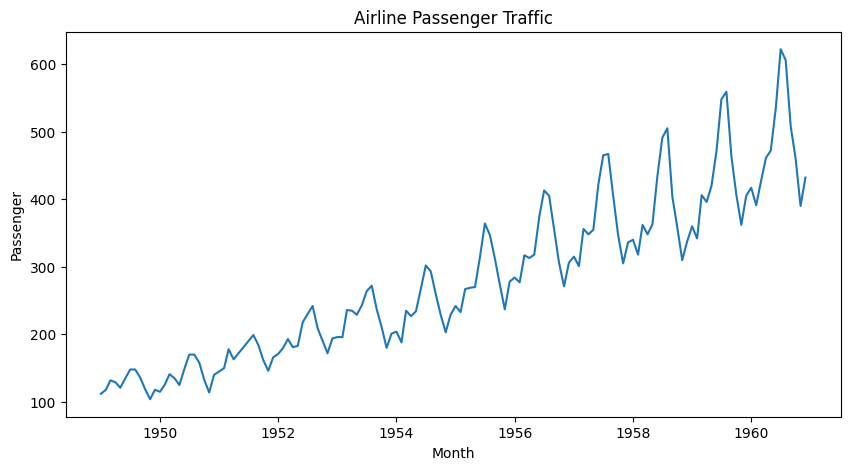

In [11]:
plt.figure(figsize=(10,5))
plt.plot(airline['Month'],airline['Passenger'])
plt.xlabel('Month')
plt.ylabel('Passenger')
plt.title('Airline Passenger Traffic')
plt.show()

In [12]:
airline.describe(percentiles=[0.25,0.35,0.50,0.6,0.75,0.95,0.99])

,Month,Passenger
count,144,144.000000
mean,1954-12-16 05:00:00,280.333333
min,1949-01-01 00:00:00,104.000000
25%,1951-12-24 06:00:00,180.750000
35%,1953-03-02 13:12:00,204.250000
50%,1954-12-16 12:00:00,267.500000
60%,1956-02-24 04:48:00,306.000000
75%,1957-12-08 18:00:00,360.500000
95%,1960-04-26 12:00:00,488.150000
99%,1960-10-18 16:04:48,585.790000


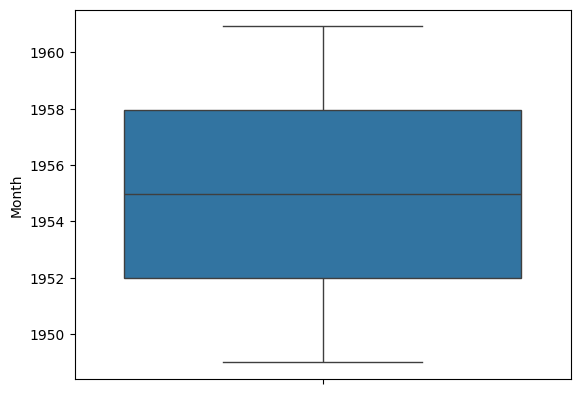

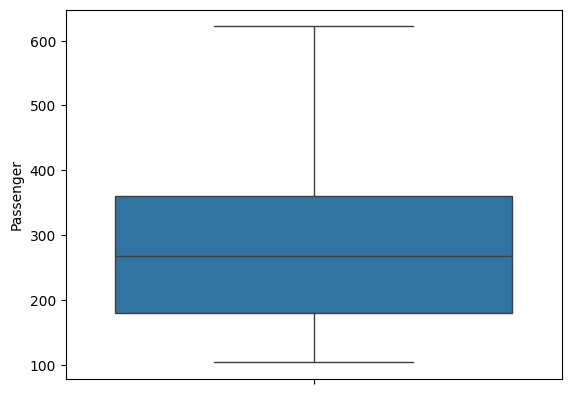

In [13]:
for i in airline.columns:
  sns.boxplot(airline[i])
  plt.show()

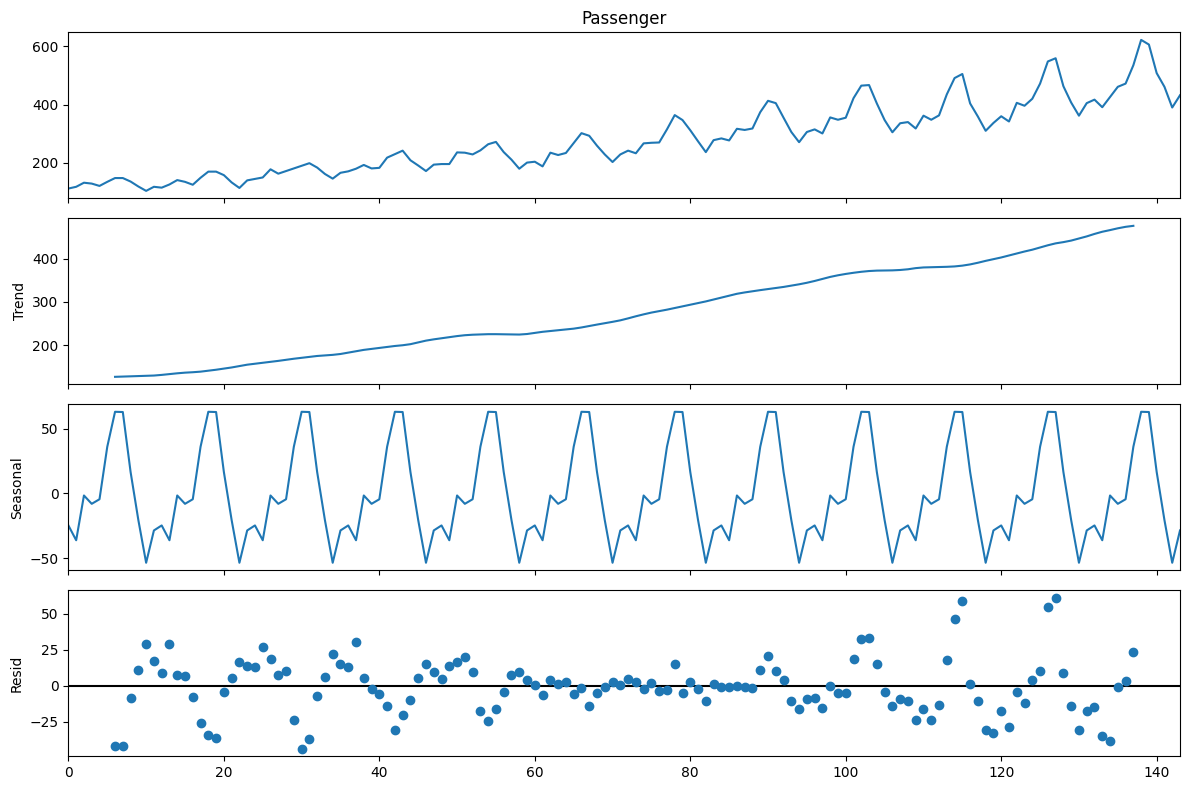

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
rcParams['figure.figsize'] = 12,8
decomposition = seasonal_decompose(airline['Passenger'], model='additive', period=12)
fig = decomposition.plot()
plt.show()

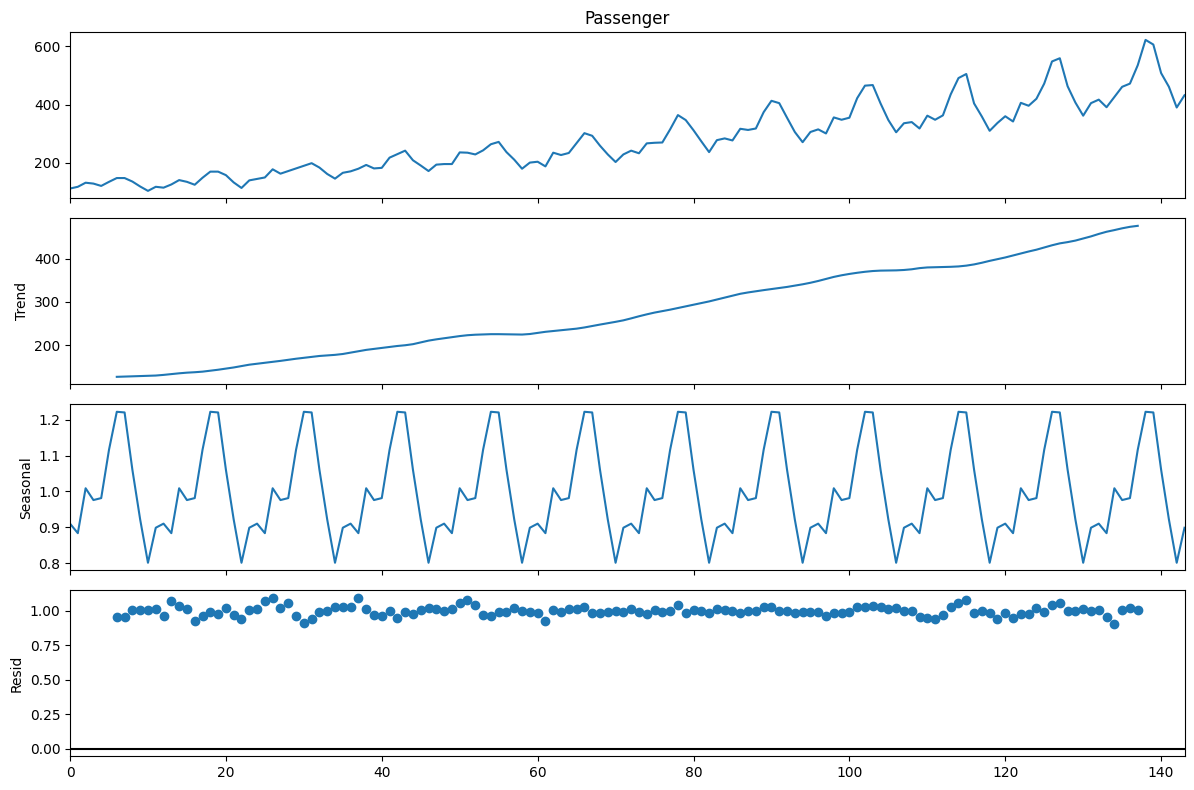

In [15]:
decomposition = seasonal_decompose(airline['Passenger'], model='multiplicative', period=12)
fig = decomposition.plot()
plt.show()

In [16]:
train_len = 120
train = airline[:train_len]
test = airline[train_len:]

### Naive Method

In [17]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['Passenger'][train_len-1]

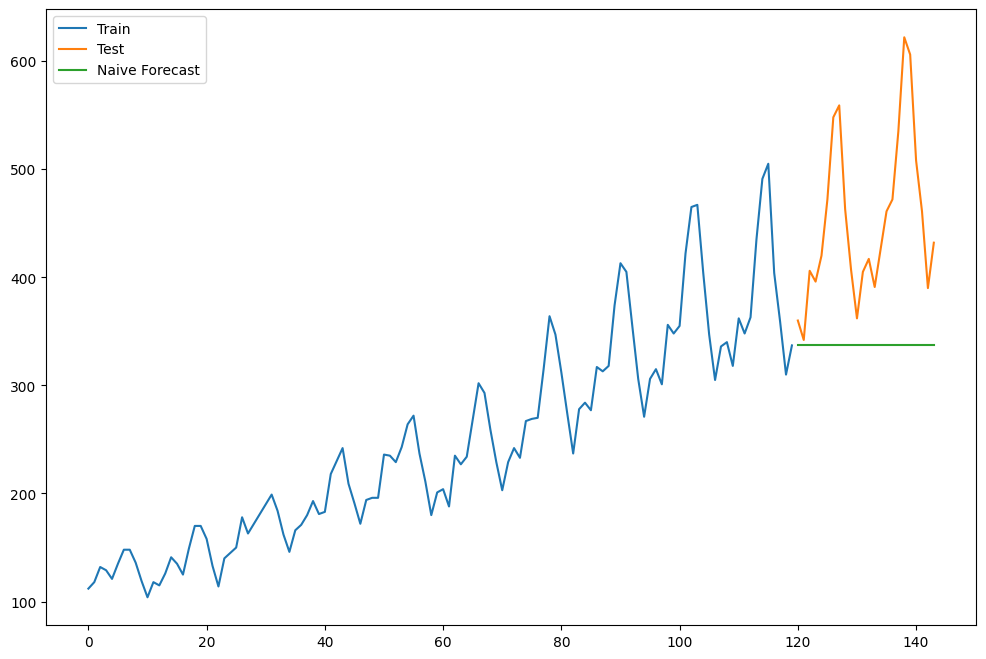

In [18]:
plt.plot(train['Passenger'],label='Train')
plt.plot(test['Passenger'],label='Test')
plt.plot(y_hat_naive['naive_forecast'],label='Naive Forecast')
plt.legend(loc='best')
plt.show()

In [19]:
rmse = round(np.sqrt(mean_squared_error(test['Passenger'],y_hat_naive['naive_forecast'])),2)
mape = round(np.mean(np.abs(test['Passenger'] - y_hat_naive['naive_forecast'])/test['Passenger'])*100,2)
print("Naive Method")
print('RMSE: ',rmse)
print('MAPE: ',mape)

Naive Method
RMSE:  137.51
MAPE:  23.63


### Simple Average Method

In [20]:
y_hat_average = test.copy()
y_hat_average['average_forecast'] = train['Passenger'].mean()

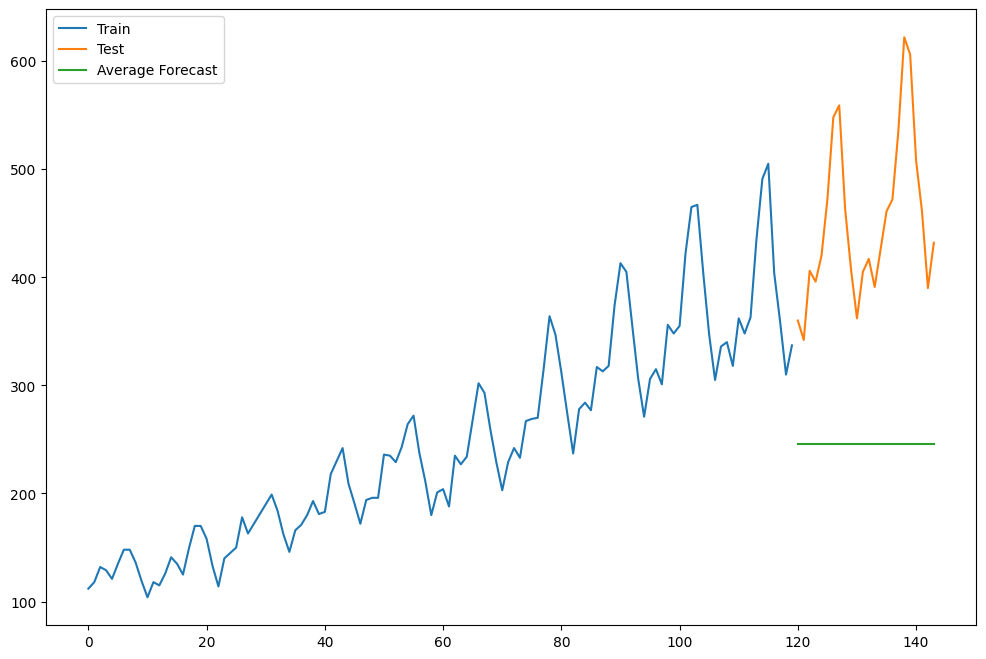

In [21]:
plt.plot(train['Passenger'],label='Train')
plt.plot(test['Passenger'],label='Test')
plt.plot(y_hat_average['average_forecast'],label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [22]:
rmse = round(np.sqrt(mean_squared_error(test['Passenger'],y_hat_average['average_forecast'])),2)
mape = round(np.mean(np.abs(test['Passenger'] - y_hat_average['average_forecast'])/test['Passenger'])*100,2)
print("Average Method")
print('RMSE: ',rmse)
print('MAPE: ',mape)

Average Method
RMSE:  219.69
MAPE:  44.28


### Simple Moving Average Method

In [30]:
y_hat_sma = test.copy()
ma_window = 12
y_hat_sma['sma_forecast'] = train['Passenger'].rolling(ma_window).mean()
# Use iloc to access the last value of the 'sma_forecast' column and assign it to the slice
y_hat_sma['sma_forecast'].iloc[train_len:] = y_hat_sma['sma_forecast'].iloc[-1]

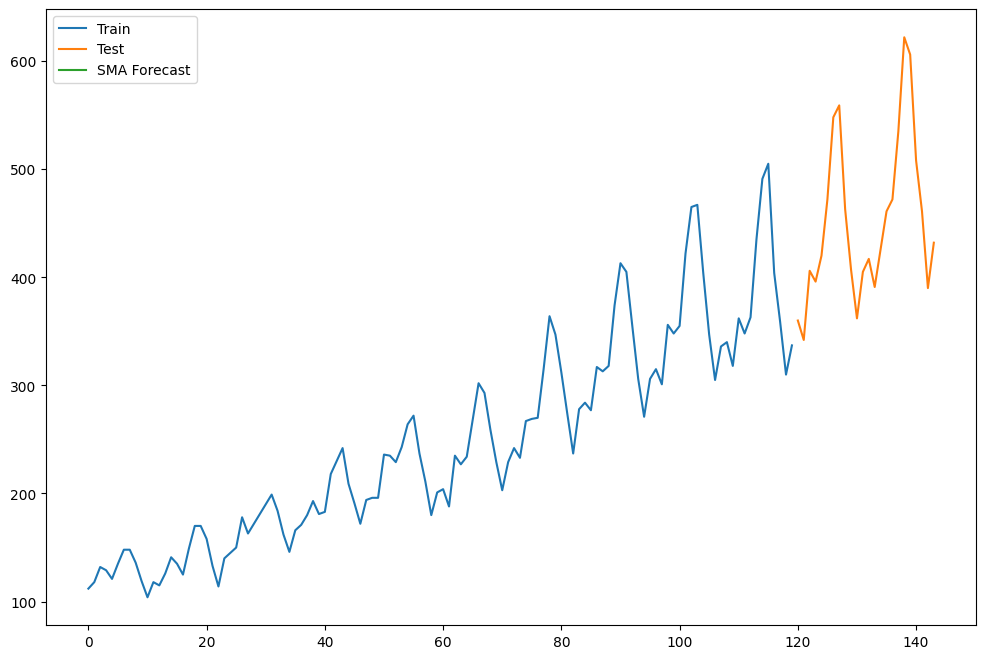

In [25]:
plt.plot(train['Passenger'],label='Train')
plt.plot(test['Passenger'],label='Test')
plt.plot(y_hat_sma['sma_forecast'],label='SMA Forecast')
plt.legend(loc='best')
plt.show()